# ===============================================================
# Shopee Seasonal Product Analysis - Full Preprocessing Pipeline
# ===============================================================

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

# ================================
# 1. Load Dataset
# ================================

In [2]:
print("Loading dataset...")
file_path = 'consolidated_file.csv'
df = pd.read_csv(file_path, low_memory=False)

print(f"Initial dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}\n")

Loading dataset...
Initial dataset shape: (674999, 32)
Columns: ['Time', 'Product', 'ID', 'Top-level category', 'Second-level category', 'Third-level category', 'Fourth-level category', 'Fifth-level category', 'Avg.SKU Price(₱)', 'Brand', 'Shop', 'Sold/Day', 'Revenue/Day(₱)', 'Sold/M', 'Product sales rate(%)', 'Price(₱)', 'Brand ID', 'Link', 'Seller From', 'SKU', 'Shop ID', 'Listing Time', 'Joined', 'Sold', 'Sold/Month(₱)', 'Revenue/Month', 'New Ratings', 'Ratings', 'Ratings Rate', 'Likes', 'Rating Star', 'New likes']



# ================================
# 2. Clean Column Names
# ================================

In [3]:
print("Cleaning column names...")
df.columns = df.columns.str.strip().str.replace(' ', '_').str.lower()
df = df.drop(columns=['unnamed:_31', 'unnamed:_32'], errors='ignore')

print(f"Cleaned columns: {df.columns.tolist()}\n")

Cleaning column names...
Cleaned columns: ['time', 'product', 'id', 'top-level_category', 'second-level_category', 'third-level_category', 'fourth-level_category', 'fifth-level_category', 'avg.sku_price(₱)', 'brand', 'shop', 'sold/day', 'revenue/day(₱)', 'sold/m', 'product_sales_rate(%)', 'price(₱)', 'brand_id', 'link', 'seller_from', 'sku', 'shop_id', 'listing_time', 'joined', 'sold', 'sold/month(₱)', 'revenue/month', 'new_ratings', 'ratings', 'ratings_rate', 'likes', 'rating_star', 'new_likes']



# ================================
# 3. Convert Data Types and Drop Unnecessary Columns
# ================================

In [4]:
# Numeric columns - remove commas and convert
numeric_cols = [
    'avg.sku_price(₱)', 'sold/day', 'revenue/day(₱)', 'sold/m',
    'product_sales_rate(%)', 'price(₱)', 'revenue/month', 'sold/month(₱)',
    'sold', 'new_ratings', 'ratings', 'likes', 'ratings_rate', 
    'rating_star', 'new_likes', 'sku'
]

for col in numeric_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).str.replace(',', '').replace('', np.nan)
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Date columns - proper conversion
print("Converting date columns...")

# Time column (YYYYMM format)
df = df.dropna(subset=['time'])  # Drop rows with missing time
df['time'] = df['time'].astype(int).astype(str) + '01'
df['time'] = pd.to_datetime(df['time'], format='%Y%m%d', errors='coerce')

# Listing_time and Joined (YYYYMMDD format)
for col in ['listing_time', 'joined']:
    if col in df.columns:
        df[col] = df[col].astype(str).str.replace('.0', '', regex=False)
        df[col] = pd.to_datetime(df[col], format='%Y%m%d', errors='coerce')

# Convert ID to string
df['id'] = df['id'].fillna(0).astype('Int64').astype(str)

print(f"Date range: {df['time'].min()} to {df['time'].max()}")
print(f"Dataset shape after date conversion: {df.shape}\n")

cols_to_drop = [
    'second-level_category',
    'third-level_category',
    'fourth-level_category',
    'fifth-level_category',
    'link',
    'joined',
    'shop_id',
    'shop',
    'brand_id',
    'brand'
]

df = df.drop(columns=cols_to_drop, errors='ignore')
print(df.columns.tolist())

Converting date columns...
Date range: 2022-03-01 00:00:00 to 2025-11-01 00:00:00
Dataset shape after date conversion: (674999, 32)

['time', 'product', 'id', 'top-level_category', 'avg.sku_price(₱)', 'sold/day', 'revenue/day(₱)', 'sold/m', 'product_sales_rate(%)', 'price(₱)', 'seller_from', 'sku', 'listing_time', 'sold', 'sold/month(₱)', 'revenue/month', 'new_ratings', 'ratings', 'ratings_rate', 'likes', 'rating_star', 'new_likes']


# ================================
# 4. Clean Categories
# ================================

In [5]:
print("Cleaning category columns...")
category_cols = [
    'top-level_category'
]

for col in category_cols:
    if col in df.columns:
        df[col] = df[col].fillna('Unknown').str.strip()

Cleaning category columns...


# ================================
# 5. Create Full Monthly Grid per Product
# ================================

In [6]:
# Get date range and unique products
all_months = pd.date_range(start=df['time'].min(), 
                           end=df['time'].max(), 
                           freq='MS')
all_products = df['product'].unique()

print(f"Number of unique products: {len(all_products)}")
print(f"Number of months: {len(all_months)}")
print(f"Expected grid size: {len(all_products) * len(all_months):,} rows")

# Create full grid
full_index = pd.MultiIndex.from_product(
    [all_products, all_months], 
    names=['product', 'time']
)
full_df = pd.DataFrame(index=full_index).reset_index()

Number of unique products: 167589
Number of months: 45
Expected grid size: 7,541,505 rows


# ================================
# 6. Merge with Actual Data
# ================================

In [7]:
print("\nMerging with actual data...")

# Merge all data
full_df = full_df.merge(
    df, 
    on=['product', 'time'], 
    how='left'
)

print(f"Full grid shape: {full_df.shape}")


Merging with actual data...
Full grid shape: (7554662, 22)


# ================================
# 7. Get Product Metadata (One Per Product)
# ================================

In [9]:
# Columns that should be constant per product
metadata_cols = [
    'id',
    'top-level_category',
    'seller_from',
    'listing_time'
]

# Get first non-null value for each product
product_metadata = df.groupby('product')[metadata_cols].first().reset_index()


# ================================
# 8. Merge Metadata and Forward-Fill
# ================================

In [10]:
# Drop existing metadata columns to avoid conflicts
full_df = full_df.drop(columns=metadata_cols, errors='ignore')

# Merge metadata
full_df = full_df.merge(product_metadata, on='product', how='left')

# Forward-fill time-varying numeric columns per product
time_varying_cols = [
    'avg.sku_price(₱)', 'price(₱)', 'sku', 
    'ratings', 'rating_star', 'likes'
]

print("Forward-filling time-varying columns...")
for col in time_varying_cols:
    if col in full_df.columns:
        full_df[col] = full_df.groupby('product')[col].ffill()


Forward-filling time-varying columns...


# ================================
# 9. Fill Missing Sales/Revenue Based on Listing Time
# ================================

In [11]:
# Strategy: Fill with 0 for months >= listing_time, keep NaN for months before listing
# This is critical for time series models to distinguish between:
# - "No data yet" (NaN before listing) vs "Zero sales" (0 after listing)

# Primary sales metrics
full_df['sold/m'] = np.where(
    full_df['time'] >= full_df['listing_time'],
    full_df['sold/m'].fillna(0),
    np.nan
)

full_df['revenue/month'] = np.where(
    full_df['time'] >= full_df['listing_time'],
    full_df['revenue/month'].fillna(0),
    np.nan
)

# Daily metrics
full_df['sold/day'] = np.where(
    full_df['time'] >= full_df['listing_time'],
    full_df['sold/day'].fillna(0),
    np.nan
)

full_df['revenue/day(₱)'] = np.where(
    full_df['time'] >= full_df['listing_time'],
    full_df['revenue/day(₱)'].fillna(0),
    np.nan
)


# ================================
# 9b. Handle Other Time-Varying Metrics
# ================================

In [12]:
print("Handling other time-varying metrics...")

# For ratings/engagement metrics: forward-fill within product's active period
# These accumulate over time, so forward-fill makes sense
engagement_cols = ['new_ratings', 'new_likes', 'product_sales_rate(%)']

for col in engagement_cols:
    if col in full_df.columns:
        # Only fill within active period (after listing)
        full_df[col] = np.where(
            full_df['time'] >= full_df['listing_time'],
            full_df.groupby('product')[col].ffill().fillna(0),
            np.nan
        )

# For "sold/month(₱)" which seems to be cumulative total sold
# Use forward-fill approach as well
if 'sold/month(₱)' in full_df.columns:
    full_df['sold/month(₱)'] = np.where(
        full_df['time'] >= full_df['listing_time'],
        full_df.groupby('product')['sold/month(₱)'].ffill().fillna(0),
        np.nan
    )

Handling other time-varying metrics...


# ================================
# 10. Filter Products for Time Series Analysis
# ================================


Filtering products suitable for time series analysis...

Product Statistics:
Total products: 167589
Products with <6 months data: 1751
Products with 6-12 months data: 7401
Products with 12+ months data: 158437
Products with 24+ months data: 126669

Recommendation: For seasonal analysis, filter to products with >= 12 months
This would retain 158437 products

Performing data quality checks...

Missing values summary (top 10):
                  Missing Count  Missing %
ratings_rate            6879718      91.07
sold                    6879663      91.07
avg.sku_price(₱)        3497470      46.30
price(₱)                3497470      46.30
sku                     3497470      46.30
ratings                 3497470      46.30
rating_star             3497470      46.30
likes                   3497470      46.30
new_ratings             1826451      24.18
new_likes               1826451      24.18

Products with no sales data: 3209

Generating visualizations...


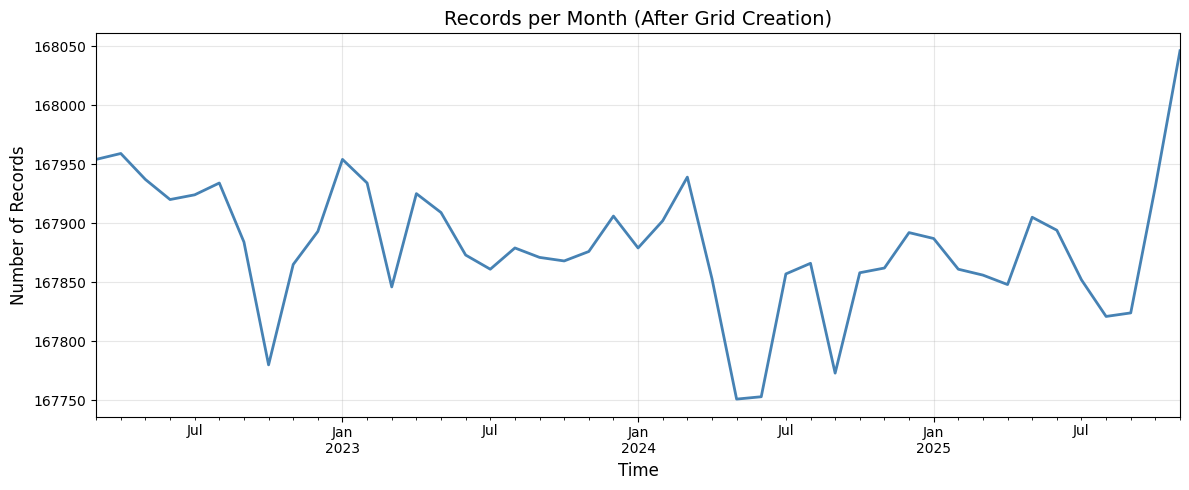

In [13]:
print("\nFiltering products suitable for time series analysis...")

# Calculate active months per product (months with non-null sales data)
product_stats = full_df.groupby('product').agg({
    'sold/m': lambda x: x.notna().sum(),  # Count of non-null months
    'time': ['min', 'max']
}).reset_index()

product_stats.columns = ['product', 'active_months', 'first_active', 'last_active']

# Calculate total months product could have been active
product_stats['potential_months'] = (
    (product_stats['last_active'].dt.year - product_stats['first_active'].dt.year) * 12 +
    (product_stats['last_active'].dt.month - product_stats['first_active'].dt.month) + 1
)

# Data completeness ratio
product_stats['data_completeness'] = product_stats['active_months'] / product_stats['potential_months']

print(f"\nProduct Statistics:")
print(f"Total products: {len(product_stats)}")
print(f"Products with <6 months data: {(product_stats['active_months'] < 6).sum()}")
print(f"Products with 6-12 months data: {((product_stats['active_months'] >= 6) & (product_stats['active_months'] < 12)).sum()}")
print(f"Products with 12+ months data: {(product_stats['active_months'] >= 12).sum()}")
print(f"Products with 24+ months data: {(product_stats['active_months'] >= 24).sum()}")

# Recommended: Filter to products with at least 12 months of data for seasonal analysis
MIN_MONTHS = 12  # Minimum months needed for seasonal decomposition
full_df = full_df.merge(product_stats[['product', 'active_months']], on='product')

print(f"\nRecommendation: For seasonal analysis, filter to products with >= {MIN_MONTHS} months")
print(f"This would retain {(product_stats['active_months'] >= MIN_MONTHS).sum()} products")

# Create a flag for analysis-ready products
full_df['suitable_for_seasonal_analysis'] = full_df['active_months'] >= MIN_MONTHS
print("\nPerforming data quality checks...")

# Check missing values
missing_summary = pd.DataFrame({
    'Missing Count': full_df.isna().sum(),
    'Missing %': (full_df.isna().sum() / len(full_df) * 100).round(2)
}).sort_values(by='Missing %', ascending=False)

print("\nMissing values summary (top 10):")
print(missing_summary.head(10))

# Check for products with no sales data
products_no_sales = full_df.groupby('product')['sold/m'].sum() == 0
print(f"\nProducts with no sales data: {products_no_sales.sum()}")

# Visualize monthly records
print("\nGenerating visualizations...")
monthly_counts = full_df.groupby('time').size()

plt.figure(figsize=(12, 5))
monthly_counts.plot(color='steelblue', linewidth=2)
plt.title('Records per Month (After Grid Creation)', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('monthly_records.png', dpi=150)
plt.show()


# ================================
# Data Quality Checks
# ================================


Performing data quality checks...

Missing values summary (top 10):
                  Missing Count  Missing %
ratings_rate            6879718      91.07
sold                    6879663      91.07
avg.sku_price(₱)        3497470      46.30
price(₱)                3497470      46.30
sku                     3497470      46.30
ratings                 3497470      46.30
rating_star             3497470      46.30
likes                   3497470      46.30
new_ratings             1826451      24.18
new_likes               1826451      24.18

Products with no sales data: 3209

Generating visualizations...


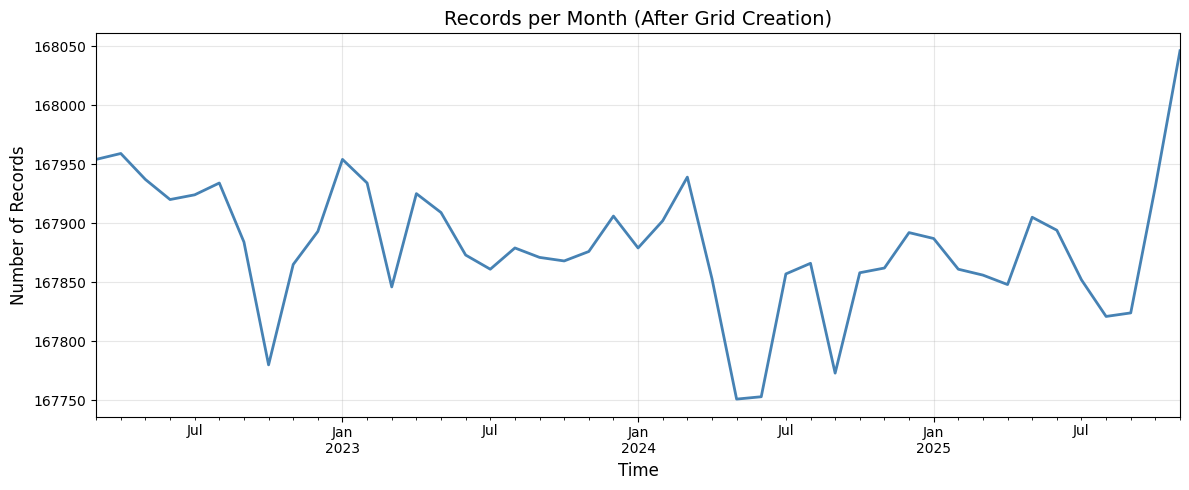

In [14]:
print("\nPerforming data quality checks...")

# Check missing values
missing_summary = pd.DataFrame({
    'Missing Count': full_df.isna().sum(),
    'Missing %': (full_df.isna().sum() / len(full_df) * 100).round(2)
}).sort_values(by='Missing %', ascending=False)

print("\nMissing values summary (top 10):")
print(missing_summary.head(10))

# Check for products with no sales data
products_no_sales = full_df.groupby('product')['sold/m'].sum() == 0
print(f"\nProducts with no sales data: {products_no_sales.sum()}")

# Visualize monthly records
print("\nGenerating visualizations...")
monthly_counts = full_df.groupby('time').size()

plt.figure(figsize=(12, 5))
monthly_counts.plot(color='steelblue', linewidth=2)
plt.title('Records per Month (After Grid Creation)', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('monthly_records.png', dpi=150)
plt.show()

# ================================
# 11. Save Cleaned Dataset
# ================================

In [15]:
print("\nSaving cleaned dataset...")

# Sort by product and time
full_df = full_df.sort_values(['product', 'time']).reset_index(drop=True)

# Save to CSV
output_file = 'consolidated_file_cleaned.csv'
full_df.to_csv(output_file, index=False)

print(f"\n{'='*60}")
print(f"PIPELINE COMPLETED SUCCESSFULLY")
print(f"{'='*60}")
print(f"Final dataset shape: {full_df.shape}")
print(f"Date range: {full_df['time'].min()} to {full_df['time'].max()}")
print(f"Number of products: {full_df['product'].nunique()}")
print(f"Number of months: {full_df['time'].nunique()}")
print(f"Output saved to: {output_file}")
print(f"{'='*60}\n")

# Display sample
print("Sample of cleaned data:")
print(full_df[['product', 'time', 'top-level_category', 'sold/m', 'revenue/month']].head(20))


Saving cleaned dataset...

PIPELINE COMPLETED SUCCESSFULLY
Final dataset shape: (7554662, 24)
Date range: 2022-03-01 00:00:00 to 2025-11-01 00:00:00
Number of products: 167589
Number of months: 45
Output saved to: consolidated_file_cleaned.csv

Sample of cleaned data:
                                              product       time  \
0      Cute Different Designs  button accessories ... 2022-03-01   
1      Cute Different Designs  button accessories ... 2022-04-01   
2      Cute Different Designs  button accessories ... 2022-05-01   
3      Cute Different Designs  button accessories ... 2022-06-01   
4      Cute Different Designs  button accessories ... 2022-07-01   
5      Cute Different Designs  button accessories ... 2022-08-01   
6      Cute Different Designs  button accessories ... 2022-09-01   
7      Cute Different Designs  button accessories ... 2022-10-01   
8      Cute Different Designs  button accessories ... 2022-11-01   
9      Cute Different Designs  button accessories 